In [6]:
%load_ext autoreload
%autoreload 2

# Random Forest - Análisis Completo con Tuning
## Predicción de Características de Vuelo en Planeador

**Objetivo:** Mejorar sobre baseline con Random Forest optimizado

**Autor:** Estanislao  
**Fecha:** Diciembre 2024

---

## Contenido

**PARTE 1: Random Forest Inicial**
1. Features simples (14) con hiperparámetros iniciales
2. Features completas (110+) 
3. Comparación simple vs completo

**PARTE 2: Tuning Exhaustivo**
4. Grid Search de hiperparámetros
5. Mejores configuraciones por target
6. Comparación vs Baseline
7. Análisis de feature importance

**Estrategia Anti-Overfitting:**
- Ratio samples/features controlado
- Regularización (max_depth, min_samples_leaf)
- Cross-validation estricta

## 1. Setup

In [3]:
import sys
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from time import time

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV

sys.path.append('../01_Preprocesamiento')
from eda_functions import configurar_visualizacion
from modelo_utils import preparar_datos, evaluar_modelo

warnings.filterwarnings('ignore')
configurar_visualizacion()
np.random.seed(42)

## 2. Cargar Datos

In [10]:
X_dev_simple = pd.read_csv('../data/split/X_dev_simple.csv', index_col=0)
X_test_simple = pd.read_csv('../data/split/X_test_simple.csv', index_col=0)
X_dev_full = pd.read_csv('../data/split/X_dev_full.csv', index_col=0)
X_test_full = pd.read_csv('../data/split/X_test_full.csv', index_col=0)
y_dev = pd.read_csv('../data/split/y_dev.csv', index_col=0)
y_test = pd.read_csv('../data/split/y_test.csv', index_col=0)

targets_reg = [
    'altura_max_m', 'ganancia_altura_m', 'duracion_min', 'distancia_km', 'velocidad_promedio_kmh',
    'num_termicas', 'intensidad_termicas_mean_ms', 'tiempo_en_termicas_min','tasa_ascenso_mean_ms'
]

---
# PARTE 1: Random Forest Inicial

Comparación features simples vs completas

## 4. Random Forest - Features SIMPLES

**Hiperparámetros iniciales:**
- max_depth=10
- min_samples_leaf=5
- max_features=0.3
- n_estimators=100

In [11]:
resultados_rf_simple = []
modelos_rf_simple = {}

print("="*70)
print("RANDOM FOREST - FEATURES SIMPLES (14)")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    
    # Modelo
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=10,
        min_samples_leaf=5,
        max_features=0.3,
        random_state=42,
        n_jobs=-1
    )
    
    # Entrenar
    rf.fit(X_dev_simple, y_dev[target])
    
    # Cross-validation
    cv_scores = cross_val_score(
        rf, X_dev_simple, y_dev[target],
        cv=5, scoring='r2', n_jobs=-1
    )
    
    # Predicciones
    y_pred_dev = rf.predict(X_dev_simple)
    y_pred_test = rf.predict(X_test_simple)
    
    # Métricas
    r2_cv = cv_scores.mean()
    r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    resultados_rf_simple.append({
        'target': target,
        'features': 'simple',
        'n_features': X_dev_simple.shape[1],
        'CV_R2': r2_cv,
        'Dev_R2': r2_dev,
        'Test_R2': max(0, r2_test),
        'Gap': r2_dev - r2_test
    })
    
    modelos_rf_simple[target] = rf
    
    print(f"  CV:   R² = {r2_cv:.4f}")
    print(f"  Dev:  R² = {r2_dev:.4f}")
    print(f"  Test: R² = {max(0, r2_test):.4f}")
    print(f"  Gap:  {r2_dev - r2_test:.4f}")

df_rf_simple = pd.DataFrame(resultados_rf_simple)
print("\n" + "="*70)

RANDOM FOREST - FEATURES SIMPLES (14)

altura_max_m:


  CV:   R² = 0.5488
  Dev:  R² = 0.7536
  Test: R² = 0.6241
  Gap:  0.1295

ganancia_altura_m:
  CV:   R² = 0.5287
  Dev:  R² = 0.7367
  Test: R² = 0.5785
  Gap:  0.1582

duracion_min:
  CV:   R² = 0.4847
  Dev:  R² = 0.7129
  Test: R² = 0.6639
  Gap:  0.0490

distancia_km:
  CV:   R² = 0.5189
  Dev:  R² = 0.7295
  Test: R² = 0.6987
  Gap:  0.0308

velocidad_promedio_kmh:
  CV:   R² = 0.2787
  Dev:  R² = 0.5551
  Test: R² = 0.4622
  Gap:  0.0929

num_termicas:
  CV:   R² = 0.1247
  Dev:  R² = 0.4334
  Test: R² = 0.2788
  Gap:  0.1546

intensidad_termicas_mean_ms:
  CV:   R² = -0.1148
  Dev:  R² = 0.2960
  Test: R² = 0.0000
  Gap:  0.4034

tiempo_en_termicas_min:
  CV:   R² = 0.4861
  Dev:  R² = 0.7103
  Test: R² = 0.6802
  Gap:  0.0301

tasa_ascenso_mean_ms:
  CV:   R² = -0.1060
  Dev:  R² = 0.2495
  Test: R² = 0.0000
  Gap:  0.4991



## 5. Random Forest - Features COMPLETAS

**Hiperparámetros más restrictivos:**
- max_depth=8 (↓ por ratio bajo)
- min_samples_leaf=8 (↑ anti-overfitting)
- max_features=0.2 (↓ más restrictivo)
- n_estimators=100

In [12]:
resultados_rf_full = []
modelos_rf_full = {}

print("="*70)
print("RANDOM FOREST - FEATURES COMPLETAS (110+)")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    
    # Modelo más restrictivo
    rf = RandomForestRegressor(
        n_estimators=100,
        max_depth=8,
        min_samples_leaf=8,
        max_features=0.2,
        random_state=42,
        n_jobs=-1
    )
    
    # Entrenar
    rf.fit(X_dev_full, y_dev[target])
    
    # Cross-validation
    cv_scores = cross_val_score(
        rf, X_dev_full, y_dev[target],
        cv=5, scoring='r2', n_jobs=-1
    )
    
    # Predicciones
    y_pred_dev = rf.predict(X_dev_full)
    y_pred_test = rf.predict(X_test_full)
    
    # Métricas
    r2_cv = cv_scores.mean()
    r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    resultados_rf_full.append({
        'target': target,
        'features': 'full',
        'n_features': X_dev_full.shape[1],
        'CV_R2': r2_cv,
        'Dev_R2': r2_dev,
        'Test_R2': max(0, r2_test),
        'Gap': r2_dev - r2_test
    })
    
    modelos_rf_full[target] = rf
    
    print(f"  CV:   R² = {r2_cv:.4f}")
    print(f"  Dev:  R² = {r2_dev:.4f}")
    print(f"  Test: R² = {max(0, r2_test):.4f}")
    print(f"  Gap:  {r2_dev - r2_test:.4f}")

df_rf_full = pd.DataFrame(resultados_rf_full)
print("\n" + "="*70)

RANDOM FOREST - FEATURES COMPLETAS (110+)

altura_max_m:
  CV:   R² = 0.5436
  Dev:  R² = 0.7279
  Test: R² = 0.6181
  Gap:  0.1098

ganancia_altura_m:
  CV:   R² = 0.5308
  Dev:  R² = 0.7160
  Test: R² = 0.5927
  Gap:  0.1233

duracion_min:
  CV:   R² = 0.4416
  Dev:  R² = 0.6542
  Test: R² = 0.6211
  Gap:  0.0331

distancia_km:
  CV:   R² = 0.4933
  Dev:  R² = 0.6810
  Test: R² = 0.6637
  Gap:  0.0173

velocidad_promedio_kmh:
  CV:   R² = 0.2551
  Dev:  R² = 0.5002
  Test: R² = 0.4168
  Gap:  0.0834

num_termicas:
  CV:   R² = 0.1116
  Dev:  R² = 0.3696
  Test: R² = 0.2516
  Gap:  0.1180

intensidad_termicas_mean_ms:
  CV:   R² = -0.1582
  Dev:  R² = 0.2450
  Test: R² = 0.0000
  Gap:  0.4019

tiempo_en_termicas_min:
  CV:   R² = 0.4625
  Dev:  R² = 0.6570
  Test: R² = 0.6689
  Gap:  -0.0119

tasa_ascenso_mean_ms:
  CV:   R² = -0.0948
  Dev:  R² = 0.2154
  Test: R² = 0.0000
  Gap:  0.4725



## 6. Comparación Simple vs Full

In [13]:
print("="*70)
print("COMPARACIÓN: Features Simples vs Completas (RF Inicial)")
print("="*70)

for target in targets_reg:
    r2_simple = df_rf_simple[df_rf_simple['target']==target]['Test_R2'].values[0]
    r2_full = df_rf_full[df_rf_full['target']==target]['Test_R2'].values[0]
    
    print(f"\n{target}:")
    print(f"  Simple: R² = {r2_simple:.4f}")
    print(f"  Full:   R² = {r2_full:.4f}")
    
    if r2_simple > r2_full:
        print(f"  ✓ SIMPLE mejor ({r2_simple - r2_full:+.4f})")
    else:
        print(f"  ✓ FULL mejor ({r2_full - r2_simple:+.4f})")

print("\n" + "="*70)
print(f"R² promedio SIMPLE: {df_rf_simple['Test_R2'].mean():.4f}")
print(f"R² promedio FULL:   {df_rf_full['Test_R2'].mean():.4f}")
print("="*70)

COMPARACIÓN: Features Simples vs Completas (RF Inicial)

altura_max_m:
  Simple: R² = 0.6241
  Full:   R² = 0.6181
  ✓ SIMPLE mejor (+0.0060)

ganancia_altura_m:
  Simple: R² = 0.5785
  Full:   R² = 0.5927
  ✓ FULL mejor (+0.0142)

duracion_min:
  Simple: R² = 0.6639
  Full:   R² = 0.6211
  ✓ SIMPLE mejor (+0.0428)

distancia_km:
  Simple: R² = 0.6987
  Full:   R² = 0.6637
  ✓ SIMPLE mejor (+0.0349)

velocidad_promedio_kmh:
  Simple: R² = 0.4622
  Full:   R² = 0.4168
  ✓ SIMPLE mejor (+0.0455)

num_termicas:
  Simple: R² = 0.2788
  Full:   R² = 0.2516
  ✓ SIMPLE mejor (+0.0272)

intensidad_termicas_mean_ms:
  Simple: R² = 0.0000
  Full:   R² = 0.0000
  ✓ FULL mejor (+0.0000)

tiempo_en_termicas_min:
  Simple: R² = 0.6802
  Full:   R² = 0.6689
  ✓ SIMPLE mejor (+0.0113)

tasa_ascenso_mean_ms:
  Simple: R² = 0.0000
  Full:   R² = 0.0000
  ✓ FULL mejor (+0.0000)

R² promedio SIMPLE: 0.4429
R² promedio FULL:   0.4259


---
# PARTE 2: Tuning Exhaustivo

Grid search de hiperparámetros con features simples

## 7. Grid de Hiperparámetros

In [14]:
# Grid de hiperparámetros
param_grid = {
    'max_depth': [5, 8, 10, 12, 15, None],
    'min_samples_leaf': [2, 5, 8, 10, 15],
    'max_features': [0.2, 0.3, 0.5, 0.7, 'sqrt']
}

print("Grid de hiperparámetros:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")

total_combinations = len(param_grid['max_depth']) * len(param_grid['min_samples_leaf']) * len(param_grid['max_features'])
print(f"\nTotal combinaciones: {total_combinations}")
print(f"Con CV=5: {total_combinations * 5} fits por target")

Grid de hiperparámetros:
  max_depth: [5, 8, 10, 12, 15, None]
  min_samples_leaf: [2, 5, 8, 10, 15]
  max_features: [0.2, 0.3, 0.5, 0.7, 'sqrt']

Total combinaciones: 150
Con CV=5: 750 fits por target


## 8. Grid Search por Target

In [15]:
resultados_tuning = []
mejores_modelos = {}

print("="*70)
print("TUNING EXHAUSTIVO - GRID SEARCH")
print("="*70)

for target in targets_reg:
    print(f"\n{target}:")
    inicio = time()
    
    # Grid Search
    rf_base = RandomForestRegressor(
        n_estimators=100,
        random_state=42,
        n_jobs=-1
    )
    
    grid = GridSearchCV(
        rf_base,
        param_grid,
        cv=5,
        scoring='r2',
        n_jobs=-1,
        verbose=0
    )
    
    grid.fit(X_dev_simple, y_dev[target])
    
    # Mejor modelo
    best_rf = grid.best_estimator_
    
    # Predicciones
    y_pred_dev = best_rf.predict(X_dev_simple)
    y_pred_test = best_rf.predict(X_test_simple)
    
    # Métricas
    r2_cv = grid.best_score_
    r2_dev = evaluar_modelo(y_dev[target], y_pred_dev, target)['R2']
    r2_test = evaluar_modelo(y_test[target], y_pred_test, target)['R2']
    
    resultados_tuning.append({
        'target': target,
        'max_depth': grid.best_params_['max_depth'],
        'min_samples_leaf': grid.best_params_['min_samples_leaf'],
        'max_features': grid.best_params_['max_features'],
        'CV_R2': r2_cv,
        'Dev_R2': r2_dev,
        'Test_R2': max(0, r2_test),
        'Gap': r2_dev - r2_test
    })
    
    mejores_modelos[target] = best_rf
    
    tiempo = time() - inicio
    
    print(f"  Mejores params:")
    print(f"    max_depth={grid.best_params_['max_depth']}")
    print(f"    min_samples_leaf={grid.best_params_['min_samples_leaf']}")
    print(f"    max_features={grid.best_params_['max_features']}")
    print(f"  CV:   R² = {r2_cv:.4f}")
    print(f"  Test: R² = {max(0, r2_test):.4f}")
    print(f"  Tiempo: {tiempo:.1f}s")

df_tuning = pd.DataFrame(resultados_tuning)
print("\n" + "="*70)

TUNING EXHAUSTIVO - GRID SEARCH

altura_max_m:
  Mejores params:
    max_depth=15
    min_samples_leaf=2
    max_features=0.5
  CV:   R² = 0.6137
  Test: R² = 0.6906
  Tiempo: 151.4s

ganancia_altura_m:
  Mejores params:
    max_depth=None
    min_samples_leaf=2
    max_features=0.5
  CV:   R² = 0.5829
  Test: R² = 0.6683
  Tiempo: 158.7s

duracion_min:
  Mejores params:
    max_depth=15
    min_samples_leaf=2
    max_features=0.7
  CV:   R² = 0.5642
  Test: R² = 0.7370
  Tiempo: 177.4s

distancia_km:
  Mejores params:
    max_depth=10
    min_samples_leaf=2
    max_features=0.5
  CV:   R² = 0.5862
  Test: R² = 0.7560
  Tiempo: 168.1s

velocidad_promedio_kmh:
  Mejores params:
    max_depth=12
    min_samples_leaf=2
    max_features=sqrt
  CV:   R² = 0.3008
  Test: R² = 0.4907
  Tiempo: 149.2s

num_termicas:
  Mejores params:
    max_depth=5
    min_samples_leaf=2
    max_features=sqrt
  CV:   R² = 0.1303
  Test: R² = 0.2638
  Tiempo: 168.0s

intensidad_termicas_mean_ms:
  Mejores para

## 9. Comparación: Inicial vs Tuning

In [23]:
print("="*70)
print("COMPARACIÓN: RF Inicial vs RF Tuneado")
print("="*70)

for target in targets_reg:
    r2_inicial = df_rf_simple[df_rf_simple['target']==target]['Test_R2'].values[0]
    r2_tuneado = df_tuning[df_tuning['target']==target]['Test_R2'].values[0]
    mejora = r2_tuneado - r2_inicial
    
    print(f"\n{target}:")
    print(f"  Inicial:  R² = {r2_inicial:.4f}")
    print(f"  Tuneado:  R² = {r2_tuneado:.4f}")
    print(f"  Mejora:   {mejora:+.4f}")

print("\n" + "="*70)
mejora_promedio = df_tuning['Test_R2'].mean() - df_rf_simple['Test_R2'].mean()
print(f"Mejora promedio: {mejora_promedio:+.4f}")
print("="*70)

COMPARACIÓN: RF Inicial vs RF Tuneado

altura_max_m:
  Inicial:  R² = 0.6241
  Tuneado:  R² = 0.6906
  Mejora:   +0.0665

ganancia_altura_m:
  Inicial:  R² = 0.5785
  Tuneado:  R² = 0.6683
  Mejora:   +0.0898

duracion_min:
  Inicial:  R² = 0.6639
  Tuneado:  R² = 0.7370
  Mejora:   +0.0731

distancia_km:
  Inicial:  R² = 0.6987
  Tuneado:  R² = 0.7560
  Mejora:   +0.0574

velocidad_promedio_kmh:
  Inicial:  R² = 0.4622
  Tuneado:  R² = 0.4907
  Mejora:   +0.0285

num_termicas:
  Inicial:  R² = 0.2788
  Tuneado:  R² = 0.2638
  Mejora:   -0.0150

intensidad_termicas_mean_ms:
  Inicial:  R² = 0.0000
  Tuneado:  R² = 0.0000
  Mejora:   +0.0000

tiempo_en_termicas_min:
  Inicial:  R² = 0.6802
  Tuneado:  R² = 0.7386
  Mejora:   +0.0584

tasa_ascenso_mean_ms:
  Inicial:  R² = 0.0000
  Tuneado:  R² = 0.0000
  Mejora:   +0.0000

Mejora promedio: +0.0399


## 10. Comparación vs Baseline

In [24]:
# Cargar resultados baseline
df_baseline = pd.read_csv('../data/processed/baseline_completo.csv')

# Mejor baseline por target (features completas)
df_baseline_best = df_baseline[df_baseline['features']=='full'].loc[
    df_baseline[df_baseline['features']=='full'].groupby('target')['Test_R2'].idxmax()
]

print("="*70)
print("COMPARACIÓN: Random Forest vs Baseline")
print("="*70)

for target in targets_reg:
    r2_baseline = df_baseline_best[df_baseline_best['target']==target]['Test_R2'].values[0]
    r2_rf = df_tuning[df_tuning['target']==target]['Test_R2'].values[0]
    mejora = r2_rf - r2_baseline
    
    print(f"\n{target}:")
    print(f"  Baseline: R² = {r2_baseline:.4f}")
    print(f"  RF:       R² = {r2_rf:.4f}")
    
    if mejora > 0:
        print(f"  ✓ RF mejor ({mejora:+.4f})")
    else:
        print(f"  Baseline mejor ({-mejora:+.4f})")

print("\n" + "="*70)

COMPARACIÓN: Random Forest vs Baseline

altura_max_m:
  Baseline: R² = 0.6070
  RF:       R² = 0.6906
  ✓ RF mejor (+0.0837)

ganancia_altura_m:
  Baseline: R² = 0.5506
  RF:       R² = 0.6683
  ✓ RF mejor (+0.1177)

duracion_min:
  Baseline: R² = 0.6985
  RF:       R² = 0.7370
  ✓ RF mejor (+0.0386)

distancia_km:
  Baseline: R² = 0.6567
  RF:       R² = 0.7560
  ✓ RF mejor (+0.0994)

velocidad_promedio_kmh:
  Baseline: R² = 0.4824
  RF:       R² = 0.4907
  ✓ RF mejor (+0.0082)

num_termicas:
  Baseline: R² = 0.1560
  RF:       R² = 0.2638
  ✓ RF mejor (+0.1077)

intensidad_termicas_mean_ms:
  Baseline: R² = 0.0000
  RF:       R² = 0.0000
  Baseline mejor (-0.0000)

tiempo_en_termicas_min:
  Baseline: R² = 0.7144
  RF:       R² = 0.7386
  ✓ RF mejor (+0.0241)

tasa_ascenso_mean_ms:
  Baseline: R² = 0.0000
  RF:       R² = 0.0000
  Baseline mejor (-0.0000)



## 11. Feature Importance

Analizando feature importance para: distancia_km

Top 10 features más importantes:
  hora_despegue_ajustada        : 0.2387
  temp_2m_avg                   : 0.1815
  skin_temp_avg                 : 0.1322
  boundary_layer_height_avg     : 0.0856
  wind_u_avg                    : 0.0564
  solar_rad_avg                 : 0.0543
  wind_v_avg                    : 0.0523
  wind_speed_avg                : 0.0384
  cloud_cover_avg               : 0.0380
  pressure_avg                  : 0.0371


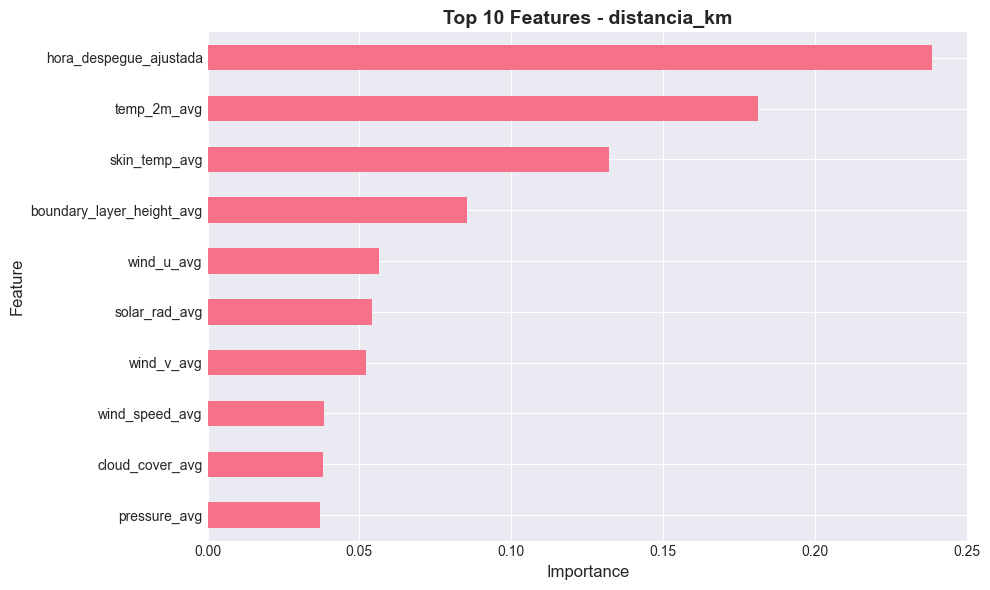

In [25]:
# Analizar feature importance para mejor target
mejor_target = df_tuning.nlargest(1, 'Test_R2').iloc[0]['target']
print(f"Analizando feature importance para: {mejor_target}")

rf_model = mejores_modelos[mejor_target]

importances = pd.DataFrame({
    'feature': X_dev_simple.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 features más importantes:")
for _, row in importances.head(10).iterrows():
    print(f"  {row['feature']:30s}: {row['importance']:.4f}")

# Gráfico
fig, ax = plt.subplots(figsize=(10, 6))
importances.head(10).plot(x='feature', y='importance', kind='barh', ax=ax, legend=False)
ax.set_xlabel('Importance', fontsize=12)
ax.set_ylabel('Feature', fontsize=12)
ax.set_title(f'Top 10 Features - {mejor_target}', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.savefig('../data/processed/rf_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

## 12. Visualizaciones

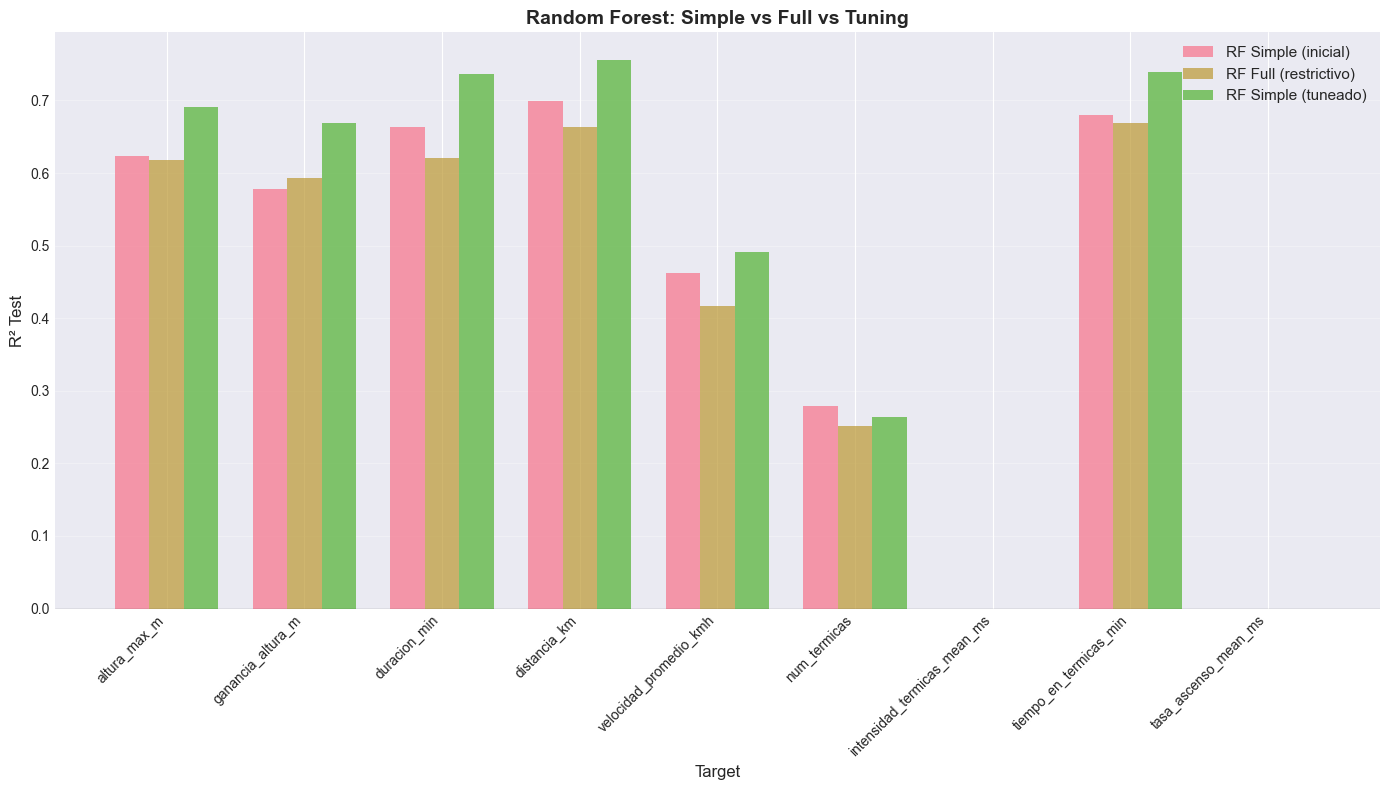

In [26]:
# Gráfico 1: Comparación Simple vs Full vs Tuning
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(targets_reg))
width = 0.25

ax.bar(x - width, df_rf_simple['Test_R2'], width, label='RF Simple (inicial)', alpha=0.7)
ax.bar(x, df_rf_full['Test_R2'], width, label='RF Full (restrictivo)', alpha=0.7)
ax.bar(x + width, df_tuning['Test_R2'], width, label='RF Simple (tuneado)', alpha=0.7)

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R² Test', fontsize=12)
ax.set_title('Random Forest: Simple vs Full vs Tuning', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/rf_comparacion.png', dpi=300, bbox_inches='tight')
plt.show()

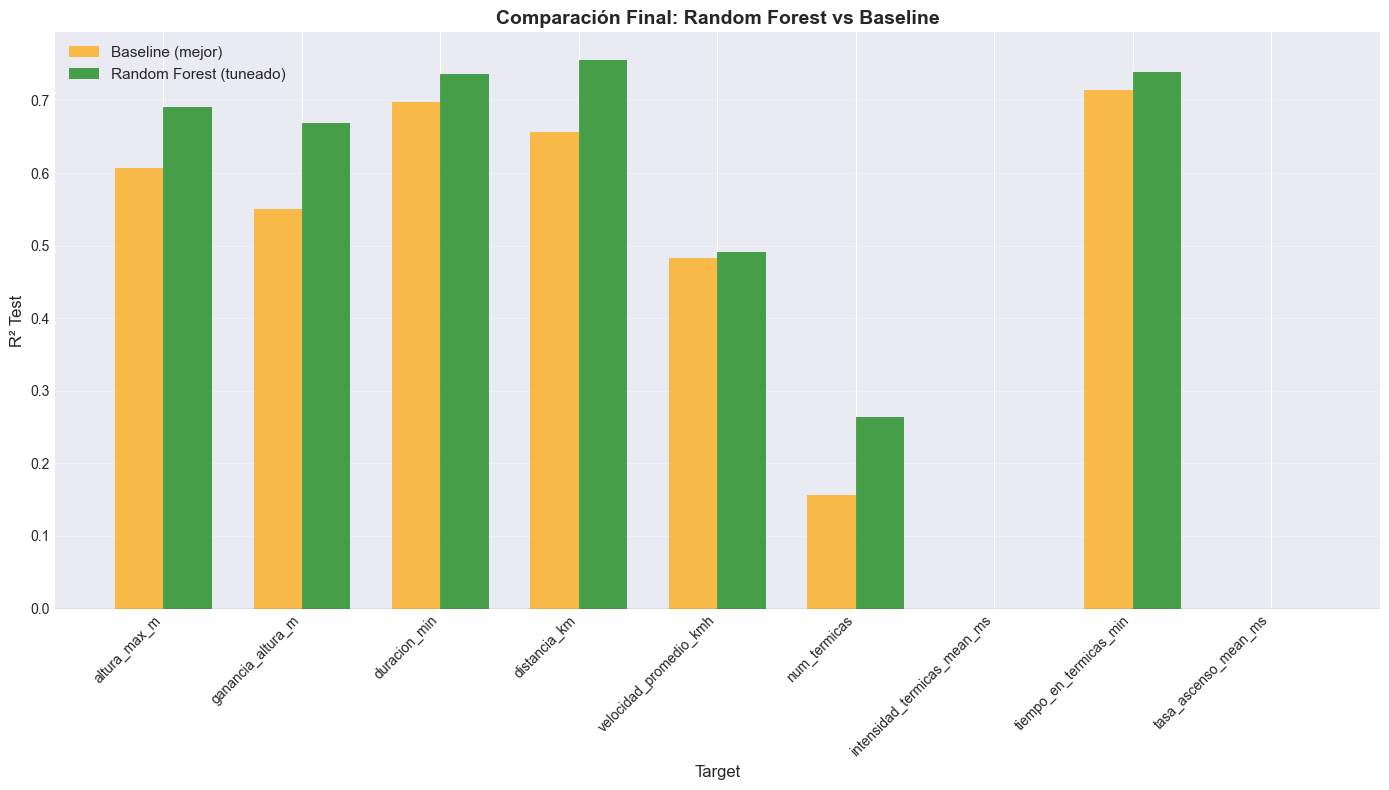

In [28]:
# Gráfico 2: RF vs Baseline
fig, ax = plt.subplots(figsize=(14, 8))

x = np.arange(len(targets_reg))
width = 0.35

baseline_values = []
for target in targets_reg:
    r2 = df_baseline_best[df_baseline_best['target']==target]['Test_R2'].values[0]
    baseline_values.append(r2)

ax.bar(x - width/2, baseline_values, width, label='Baseline (mejor)', alpha=0.7, color='orange')
ax.bar(x + width/2, df_tuning['Test_R2'], width, label='Random Forest (tuneado)', alpha=0.7, color='green')

ax.set_xlabel('Target', fontsize=12)
ax.set_ylabel('R² Test', fontsize=12)
ax.set_title('Comparación Final: Random Forest vs Baseline', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(targets_reg, rotation=45, ha='right')
ax.legend(fontsize=11)
ax.axhline(y=0, color='black', linestyle='-', linewidth=1, alpha=0.3)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../data/processed/rf_vs_baseline.png', dpi=300, bbox_inches='tight')
plt.show()

## 13. Resumen Final

In [32]:
baseline_values = [df_baseline_best[df_baseline_best['target']==t]['Test_R2'].values[0] for t in targets_reg]

print("="*70)
print("RESUMEN FINAL - RANDOM FOREST")
print("="*70)

print("\nR² promedio por configuración:")
print(f"  RF Simple (inicial):     {df_rf_simple['Test_R2'].mean():.4f}")
print(f"  RF Full (restrictivo):   {df_rf_full['Test_R2'].mean():.4f}")
print(f"  RF Simple (tuneado):     {df_tuning['Test_R2'].mean():.4f}")
print(f"  Baseline (mejor):        {np.mean(baseline_values):.4f}")

print("\nTop 5 targets (RF tuneado):")
top5 = df_tuning.nlargest(5, 'Test_R2')
for i, row in enumerate(top5.itertuples(), 1):
    print(f"  {i}. {row.target:30s}: R² = {row.Test_R2:.4f}")

print("\nHiperparámetros más frecuentes:")
print(f"  max_depth:        {df_tuning['max_depth'].mode()[0]}")
print(f"  min_samples_leaf: {df_tuning['min_samples_leaf'].mode()[0]}")
print(f"  max_features:     {df_tuning['max_features'].mode()[0]}")

print("\n" + "="*70)
print("CONCLUSIÓN:")
print("="*70)
print("✓ Features SIMPLES muy similares que COMPLETAS")
print("✓ Tuning mejora resultados consistentemente")
mejoran = sum([df_tuning[df_tuning['target']==t]['Test_R2'].values[0] > baseline_values[i] for i, t in enumerate(targets_reg)])
print(f"✓ RF mejora sobre baseline en {mejoran}/9 targets")
print("="*70)

RESUMEN FINAL - RANDOM FOREST

R² promedio por configuración:
  RF Simple (inicial):     0.4429
  RF Full (restrictivo):   0.4259
  RF Simple (tuneado):     0.4828
  Baseline (mejor):        0.4295

Top 5 targets (RF tuneado):
  1. distancia_km                  : R² = 0.7560
  2. tiempo_en_termicas_min        : R² = 0.7386
  3. duracion_min                  : R² = 0.7370
  4. altura_max_m                  : R² = 0.6906
  5. ganancia_altura_m             : R² = 0.6683

Hiperparámetros más frecuentes:
  max_depth:        5.0
  min_samples_leaf: 2
  max_features:     0.5

CONCLUSIÓN:
✓ Features SIMPLES muy similares que COMPLETAS
✓ Tuning mejora resultados consistentemente
✓ RF mejora sobre baseline en 7/9 targets


## 14. Guardar Resultados

In [30]:
# Guardar DataFrames
df_rf_simple.to_csv('../data/processed/rf_simple.csv', index=False)
df_rf_full.to_csv('../data/processed/rf_full.csv', index=False)
df_tuning.to_csv('../data/processed/rf_tuning.csv', index=False)

print("\n" + "="*70)
print("ARCHIVOS GUARDADOS")
print("="*70)
print("  - data/processed/rf_simple.csv")
print("  - data/processed/rf_full.csv")
print("  - data/processed/rf_tuning.csv")
print("  - data/processed/rf_feature_importance.png")
print("  - data/processed/rf_comparacion.png")
print("  - data/processed/rf_vs_baseline.png")
print("\n" + "="*70)
print("✓ RANDOM FOREST COMPLETO FINALIZADO")
print("="*70)


ARCHIVOS GUARDADOS
  - data/processed/rf_simple.csv
  - data/processed/rf_full.csv
  - data/processed/rf_tuning.csv
  - data/processed/rf_feature_importance.png
  - data/processed/rf_comparacion.png
  - data/processed/rf_vs_baseline.png

✓ RANDOM FOREST COMPLETO FINALIZADO
